# Bookkeeping
This notebook is used to check the status of processing tasks for the project and make lists of to-do items.


## Data structure
Cases are 


Each case needs to have the following for both Aqua and Terra
- modis truecolor
- modis falsecolor
- modis cloudfraction
- modis landmask

They're stored in the `data/modis` folder. There should be a file for each case and for each satellite.

## TBD
- Add step to check whether the image dimensions are correct.

In [2]:
import pandas as pd
import numpy as np
import os
import pyproj 

## Verify MODIS data availability

In [3]:
regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)
# cases = pd.read_csv('../data/metadata/validation_dataset_case_list.csv')
case_df = pd.read_csv('../data/metadata/merged_validation_table.csv')
case_df['case_number'] = [str(x).zfill(3) for x in case_df['case_number']]

# satellite = ['aqua']*len(case_numbers) + ['terra']*len(case_numbers)
# case_df = pd.DataFrame({'case_number': case_numbers*2,
                        # 'satellite': satellite})

modis_loc = '../data/modis/'
truecolor_files = os.listdir(modis_loc + 'truecolor')
falsecolor_files = os.listdir(modis_loc + 'falsecolor')
cloudfraction_files = os.listdir(modis_loc + 'cloudfraction')
landmask_files = os.listdir(modis_loc + 'landmask')

# Organize the data from the filenames into dataframes
fc_df = pd.DataFrame([x.replace('.', '-').split('-') for x in falsecolor_files if '.tiff' in x],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])
tc_df = pd.DataFrame([x.replace('.', '-').split('-') for x in truecolor_files if '.tiff' in x],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])
cl_df = pd.DataFrame([x.replace('.', '-').split('-') for x in cloudfraction_files if '.tiff' in x],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])
lm_df = pd.DataFrame([x.replace('.', '-').split('-') for x in landmask_files if '.tiff' in x],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])

# # Landmask doesn't vary with date or satellite so those values not included in filename
# lm_df = pd.DataFrame([x.replace('.', '-').split('-') for x in landmask_files],
#                      columns=['case_number', 'region', 'dx', 'imtype', 'ftype'])

# Use series of merges to check the imagery for each satellite
ref_df = case_df.merge(tc_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df = ref_df.loc[:, ['case_number', 'satellite', 'imtype']].merge(fc_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
print(ref_df.shape)

ref_df['truecolor'] = ref_df['imtype_x'].notnull()
ref_df['falsecolor'] = ref_df['imtype_y'].notnull()
ref_df.drop(['imtype_x', 'imtype_y'], axis=1, inplace=True)

ref_df = ref_df.merge(cl_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df['cloudfraction'] = ref_df['imtype'].notnull()
ref_df.drop('imtype', axis=1, inplace=True)

ref_df = ref_df.merge(lm_df.loc[:, ['case_number', 'satellite', 'imtype']],
                      left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df['landmask'] = ref_df['imtype'].notnull()
ref_df.drop('imtype', axis=1, inplace=True)

(378, 4)


In [4]:
ref_df.columns

Index(['case_number', 'satellite', 'truecolor', 'falsecolor', 'cloudfraction',
       'landmask'],
      dtype='object')

In [5]:
for x in landmask_files:
    if len(x.replace('.', '-').split('-')) != 8:
        print(x)

In [6]:
print('MODIS data availability\n-----------------------')
expected = len(case_df)
for imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'landmask']:
    n = ref_df[imtype].notnull().sum()
    if n == expected:
        print(imtype, n, '/', expected)
    else:
        print(imtype, n, '/', expected, 'missing {x} files'.format(x=expected - n))
        print('    ', 'data missing from case(s)', ', '.join(np.unique(ref_df.loc[~ref_df[imtype],'case_number'].values)))

MODIS data availability
-----------------------
truecolor 378 / 378
falsecolor 378 / 378
cloudfraction 378 / 378
landmask 378 / 378


# MASIE data availability
- full image downloaded?
- cropped image created?

# Initializing the validation data tables
Image metadata from prior work is in the init_validation_tables folder. We'll merge this table with the new samples, and create an updated validation table to put the image annotations in.


In [136]:
init_data.columns

NameError: name 'init_data' is not defined

In [137]:
print('QA Review needed for one image')
data.loc[data.qa_reviewer.isnull(), ['case_number', 'region', 'satellite', 'qa_analyst', 'qa_reviewer']]

QA Review needed for one image


,case_number,region,satellite,qa_analyst,qa_reviewer
12,007,baffin_bay,aqua,daniel,NaN
13,007,baffin_bay,terra,daniel,NaN
20,011,baffin_bay,aqua,daniel,NaN
21,011,baffin_bay,terra,daniel,NaN
24,013,baffin_bay,aqua,daniel,NaN
...,...,...,...,...,...
329,165,laptev_sea,terra,daniel,NaN
348,175,sea_of_okhostk,aqua,NaN,NaN
349,175,sea_of_okhostk,terra,NaN,NaN
376,189,sea_of_okhostk,aqua,daniel,NaN


Next, we need to see if the information in the "floe labeling analyst" (`fl_analyst`) category is correct.

# Checking the status of the validation imagery
Validation imagery comes in multiple categories: manually labeled and algorithmic labels. In the former category, we are checking the floe labeling column against the files found in the `labeled_floes_png`, `labeled_landfast_ice`, and `landmask_png` folders. 

First, we look to see if any images are listed in the data table that are missing from the folder.

If nothing prints, then all the images listed in the table are present.

In [8]:
imtype = 'labeled_floes' # landmask, # labeled_floes
dataloc = '../data/validation_images/'
tbd = []
for row, case in case_df.iterrows():
    cn = str(case.case_number).zfill(3)
    region = case.region
    start = case.start_date
    satellite = case.satellite
    if case.notnull().fl_analyst:
        missing = []
        for imtype in ['labeled_floes', 'landmask', 'labeled_landfast']:
            image_path = dataloc + imtype + '/' + '-'.join([cn, region, start.replace('-', ''), satellite, imtype]) + '.png'               
            if not os.path.isfile(image_path):
                missing.append(imtype)    
        if len(missing) > 0:
            print(cn, satellite, region, ' '.join(missing), case.fl_analyst)
    elif case.visible_floes == 'yes':
        tbd.append('-'.join([cn, satellite, region]))

In [139]:
len(tbd)

114

Next, check if any files in the folder aren't in the table.

Labeled floes:

In [9]:
files = [f for f in os.listdir(dataloc + 'labeled_floes') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = case_df.loc[((case_df.case_number == cn) & (case_df.region == region)) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

044-beaufort_sea-20200808-aqua-labeled_floes.png
044-beaufort_sea-20200808-terra-labeled_floes.png


Labeled landfast:

In [10]:
files = [f for f in os.listdir(dataloc + 'labeled_landfast') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = case_df.loc[((case_df.case_number == cn) & (case_df.region == region)) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

044-beaufort_sea-20200808-aqua-labeled_landfast.png
044-beaufort_sea-20200808-terra-labeled_landfast.png


Landmask:

In [11]:
files = [f for f in os.listdir(dataloc + 'landmask') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = case_df.loc[((case_df.case_number == cn) & (case_df.region == region)) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

044-beaufort_sea-20200808-aqua-landmask.png
044-beaufort_sea-20200808-terra-landmask.png


Photoshop file:

In [12]:
files = [f for f in os.listdir(dataloc + 'labeling_psd_files/labeling_done') if 'psd' in f]
files.sort()
for file in files:
    cn = file.split('-')[0]
    if 'aqua' in file:
        satellite == 'aqua'
    else:
        satellite == 'terra'
    
    row = case_df.loc[(case_df.case_number == cn) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.notnull()['fl_analyst'].values[0]:
            if row.isnull()['psd_file'].values[0]:
                print(file)
    else:
        print(file, 'Missing from table')

# TBD

Number of floes needing review, metadata needed, and metadata review needed

In [13]:
print('Metadata needed:', len(case_df.loc[case_df.qa_analyst.isnull()]))
print('Metadata review needed:', len(case_df.loc[case_df.qa_analyst.notnull() & case_df.qa_reviewer.isnull()]))

print('Total images w/ floes:', len(case_df.loc[(case_df.visible_floes == 'yes'),:]))
print('Total labeled images:', len(case_df.loc[(case_df.visible_floes == 'yes') & case_df.fl_analyst.notnull(),:]))
print('Images remaining:', len(case_df.loc[((case_df.visible_floes == 'yes')) & (case_df.fl_analyst.isnull()),:]))
print('Floe labeling review needed:', len(case_df.loc[case_df.fl_analyst.notnull() & case_df.fl_reviewer.isnull()]))

Metadata needed: 0
Metadata review needed: 127
Total images w/ floes: 223
Total labeled images: 121
Images remaining: 102
Floe labeling review needed: 92


Remaining images to process by region:

In [14]:
case_df.loc[(((case_df.visible_floes == 'yes')) & (case_df.fl_analyst.isnull())),
['case_number', 'region']].groupby('region').count()

,case_number
region,
baffin_bay,10
barents_kara_seas,10
beaufort_sea,21
bering_chukchi_seas,15
east_siberian_sea,18
greenland_sea,11
hudson_bay,16
sea_of_okhostk,1


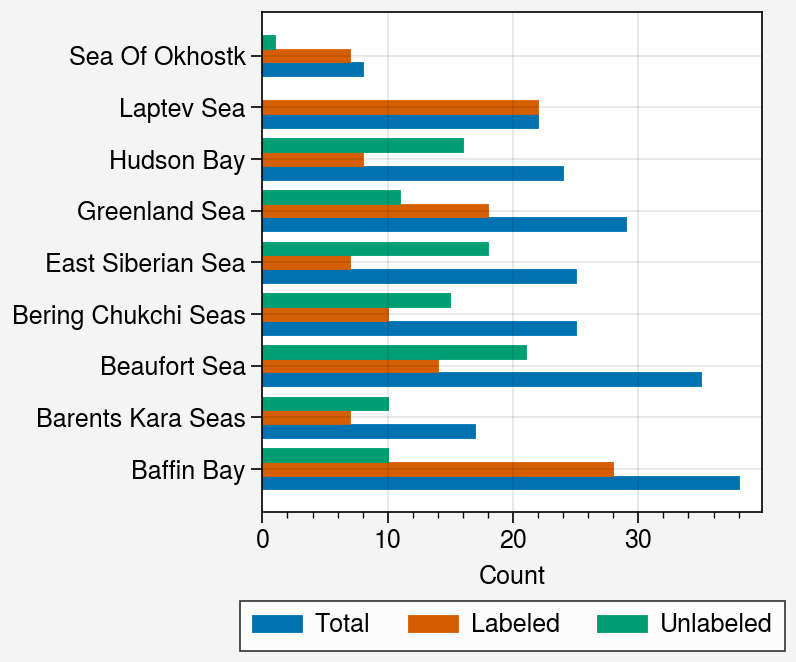

In [15]:
import proplot as pplt
data = case_df.copy()
total_to_label = data.loc[data.visible_floes == 'yes'].groupby('region').count()['case_number']
total_labeled = data.loc[(data.visible_floes == 'yes') & data.fl_analyst.notnull(),:].groupby('region').count()['case_number']
total_unlabeled = data.loc[(data.visible_floes == 'yes') & data.fl_analyst.isnull(),:].groupby('region').count()['case_number']
df = pd.DataFrame({'Total': total_to_label, 'Labeled': total_labeled, 'Unlabeled': total_unlabeled})
df.index = [x.replace('_', ' ').title() for x in df.index]
fig, ax = pplt.subplots()
ax.barh(df)
ax.format(xlabel='Count')
ax.legend(loc='b')

/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/shapely/constructive.py:181

/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


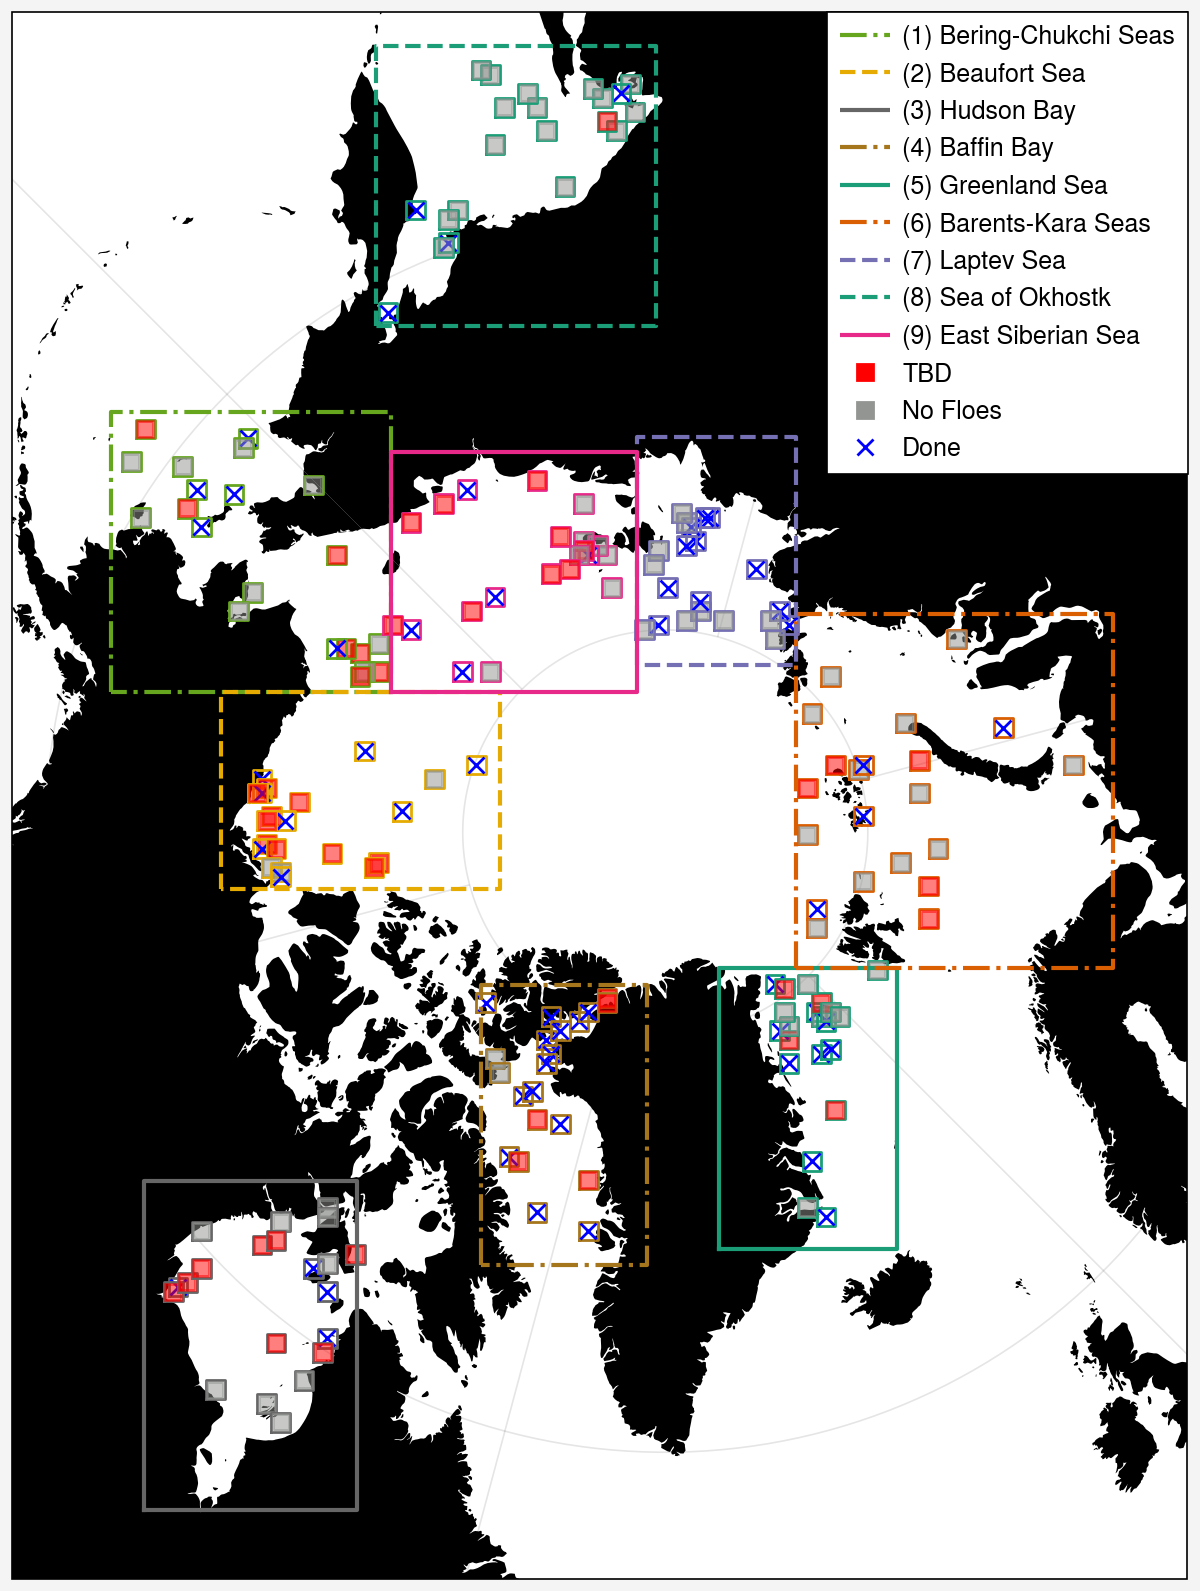

In [16]:
import proplot as pplt
import cartopy.crs as ccrs

df = pd.read_csv('../data/metadata/merged_validation_table.csv')
df = df.loc[df.satellite=='aqua']
df.index = [str(x).zfill(3) for x in df.case_number]

regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
linestyles = {region: ls for region, ls in zip(regions.index,
                        ['-', '-.', '--', '-', '-.', '--', '-.', '-', '--'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')

for idx, row in regions.iterrows():
    if row.print_title == 'Barents Kara Seas':
        regions.loc[idx, 'print_title'] = 'Barents-Kara Seas'
    if row.print_title == 'Bering Chukchi Seas':
        regions.loc[idx, 'print_title'] = 'Bering-Chukchi Seas'

pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, ax = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=1)
ax.format(land=True, landzorder=0)

validated_cases = df.loc[df.fl_analyst.notnull()]
needs_validation = df.loc[df.fl_analyst.isnull() & (df.visible_floes == 'yes')]

no_floes_cases = df.loc[df.visible_floes == 'no']

for idx, region, lat, lon in zip(range(len(regions)), regions.index, regions.center_lat, regions.center_lon):

    xbox = np.array(regions.loc[region, ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']].astype(float))
    ybox = np.array(regions.loc[region, ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']].astype(float))
    
    ax.plot(xbox, ybox, transform=ccrs.CRS('epsg:3413'),
            label='({n}) {t}'.format(n=idx + 1, t=regions.loc[region, 'print_title']), 
               color=colors[region], ls=linestyles[region], m='', zorder=5, lw=1.5)
    
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)
for idx, case in df.iterrows():
    x0 = case.center_x
    y0 = case.center_y
    left = x0 - 50e3
    right = x0 + 50e3
    bottom = y0 - 50e3
    top = y0 + 50e3 
    region = case.region

    ax.plot([left, left, right, right, left],
        [bottom, top, top, bottom, bottom], label='',
            transform=crs, color=colors[region], lw=1)
    if str(case.case_number).zfill(3) in validated_cases.index:
        ax.plot(x0, y0, m='x', color='b', transform=crs, label='')
    elif str(case.case_number).zfill(3) in no_floes_cases.index:
        ax.plot(x0, y0, m='s', color='gray', transform=crs, alpha=0.5, label='')
    elif str(case.case_number).zfill(3) in needs_validation.index:
        ax.plot(x0, y0, m='s', color='r', transform=crs, alpha=0.5, label='')        

ax.plot([],[],m='s', color='r', label='TBD', lw=0)
ax.plot([],[],m='s', color='gray', label='No Floes', lw=0)
ax.plot([],[],m='x', color='b', label='Done', lw=0)
ax.legend(ncols=1, alpha=1)

In [125]:
validated_cases

,case_number,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,...,visible_floes,cloud_fraction_manual,cloud_category_manual,artifacts,qa_analyst,qa_reviewer,fl_analyst,fl_reviewer,psd_file,notes
001,1,baffin_bay,2022-09-11,-91.527525,77.801013,-962500,-912500,9,1.000,0.573,...,yes,0.4,thin,yes,ethan,daniel,daniel,NaN,yes,reclassified landfast ice (likely cloud deck)
004,4,baffin_bay,2019-09-25,-76.809389,79.302903,-612500,-987500,9,1.000,0.822,...,yes,0.8,scattered,yes,ethan,daniel,emma,daniel,yes,NaN
005,5,baffin_bay,2013-03-08,-74.814163,78.203720,-637500,-1112500,3,1.000,0.845,...,yes,0.3,scattered,no,ethan,daniel,daniel,NaN,yes,NaN
006,6,baffin_bay,2022-05-30,-73.361194,75.260786,-762500,-1412500,5,1.000,0.785,...,yes,0.1,opaque,yes,ethan,daniel,emma,daniel,yes,NaN
007,7,baffin_bay,2007-08-25,-72.897271,78.935174,-562500,-1062500,8,0.944,0.419,...,yes,0.9,thin,no,daniel,NaN,daniel,NaN,yes,NaN
008,8,baffin_bay,2011-05-06,-72.284207,77.710993,-612500,-1187500,5,1.000,0.885,...,yes,0.7,opaque,no,ethan,daniel,ellen,NaN,yes,daniel: added a few additional floes
009,9,baffin_bay,2012-04-22,-72.255328,77.200903,-637500,-1237500,4,1.000,0.687,...,yes,0.4,thin,yes,ethan,daniel,emma,daniel,yes,NaN
010,10,baffin_bay,2021-06-02,-72.181111,75.673625,-712500,-1387500,6,1.000,0.758,...,yes,1.0,thin,no,ethan,daniel,daniel,NaN,yes,NaN
012,12,baffin_bay,2009-04-26,-69.550452,79.750680,-462500,-1012500,4,1.000,0.856,...,yes,0.1,scattered,yes,ethan,daniel,ellen,NaN,yes,NaN
015,15,baffin_bay,2021-08-04,-68.198591,80.355209,-412500,-962500,8,1.000,0.662,...,yes,0.7,thin,no,ethan,daniel,ethan,daniel,yes,NaN


In [125]:
all_cases.reset_index(inplace=True, drop=True)

In [126]:
for region in merged_tables:
    print(region, merged_tables[region].shape)

baffin_bay (42, 19)
barents_kara_seas (42, 18)
beaufort_sea (42, 18)
bering_strait (42, 18)
chukchi_east_siberian_seas (42, 18)
greenland_sea (42, 18)
hudson_bay (42, 18)
laptev_sea (42, 18)
sea_of_okhostk (42, 18)


In [127]:
merged_tables[region].columns

Index(['case_number', 'long_name', 'region', 'start_date', 'end_date',
       'satellite', 'visible_sea_ice', 'visible_landfast_ice', 'visible_floes',
       'cloud_fraction', 'cloud_category', 'artifacts', 'qa_analyst',
       'qa_reviewer', 'fl_analyst', 'fl_reviewer', 'notes', 'temp_col'],
      dtype='object')

In [88]:
for idx, row in new_table.iterrows():
    date = pd.to_datetime(row.start_date)
    dt = pd.to_timedelta(1, unit='D')
    new_table.loc[idx, 'longname'] = '-'.join([str(row.case_number).zfill(3),
                                               row.region,
                                               '100km',
                                               date.strftime('%Y%m%d'),
                                               (date + dt).strftime('%Y%m%d')])
                            

array([401, 402, 403, 418, 422, 431, 432, 433, 435, 439, 440, 457, 458,
       459, 460, 461, 462, 463, 464, 465, 466])

In [20]:
image_loc = '../data/validation_images/'
fc_images = os.listdir(image_loc + 'falsecolor')
tc_images = os.listdir(image_loc + 'truecolor')

In [21]:
cases['aqua_downloaded'] = False
cases['terra_downloaded'] = False
for idx, row in cases.iterrows():
    aqua_fcname = '_'.join([str(row.case_number).zfill(3),
                           row.region, # adjust to tweaked region names 
                           '100km',
                           pd.to_datetime(row.start_date).strftime('%Y%m%d')]) + \
                            '.aqua.falsecolor.250m.tiff'
    aqua_tcname = aqua_fcname.replace('falsecolor', 'truecolor')
    terra_fcname = aqua_fcname.replace('aqua', 'terra')
    terra_tcname = terra_fcname.replace('falsecolor', 'truecolor')
    if (aqua_fcname in fc_images) & (aqua_tcname in tc_images):
        cases.loc[idx, 'aqua_downloaded'] = True
    if (terra_fcname in fc_images) & (terra_tcname in tc_images):
        cases.loc[idx, 'terra_downloaded'] = True
        

In [22]:
print('Remaining images to download:', len(cases.loc[~cases.aqua_downloaded]))

Remaining images to download: 28


## Merging the existing tables with the updated tables
* Align the case numbers, adding new rows and dropping rows no longer in sample
* Add the new ice concentration data (ideally also adding MASIE data)
* 


In [65]:
old_tables['baffin_bay']

,case_number,long_name,region,start_date,end_date,satellite,dx_km,visible_sea_ice,visible_landfast_ice,visible_floes,cloud_fraction,cloud_category,artifacts,qa_analyst,qa_reviewer,fl_analyst_comparison,fl_analyst,fl_reviewer,notes
0,0,000-baffin_bay-100km_by_100km-20040725-20040726,baffin_bay,2004-07-25,2004-07-26,aqua,100,yes,no,yes,1.0,thin,no,ethan,daniel,daniel,NaN,NaN,added landfast ice to all - es
1,0,000-baffin_bay-100km_by_100km-20040725-20040726,baffin_bay,2004-07-25,2004-07-26,terra,100,yes,no,yes,1.0,thin,no,daniel,emma,daniel,NaN,NaN,NaN
2,2,002-baffin_bay-100km_by_100km-20040921-20040922,baffin_bay,2004-09-21,2004-09-22,aqua,100,no,no,no,1.0,opaque,no,ethan,daniel,NaN,NaN,NaN,NaN
3,2,002-baffin_bay-100km_by_100km-20040921-20040922,baffin_bay,2004-09-21,2004-09-22,terra,100,no,no,no,1.0,opaque,no,daniel,emma,NaN,NaN,NaN,NaN
4,4,004-baffin_bay-100km_by_100km-20050819-20050820,baffin_bay,2005-08-19,2005-08-20,aqua,100,yes,yes,no,0.1,thin,no,ethan,daniel,NaN,NaN,NaN,NaN
5,4,004-baffin_bay-100km_by_100km-20050819-20050820,baffin_bay,2005-08-19,2005-08-20,terra,100,yes,yes,no,0.1,thin,no,daniel,emma,NaN,NaN,NaN,NaN
6,5,005-baffin_bay-100km_by_100km-20050827-20050828,baffin_bay,2005-08-27,2005-08-28,aqua,100,yes,no,yes,0.8,scattered,yes,ethan,daniel,daniel,NaN,NaN,NaN
7,5,005-baffin_bay-100km_by_100km-20050827-20050828,baffin_bay,2005-08-27,2005-08-28,terra,100,yes,no,yes,1.0,scattered,yes,daniel,emma,daniel,NaN,NaN,NaN
8,7,007-baffin_bay-100km_by_100km-20070605-20070606,baffin_bay,2007-06-05,2007-06-06,aqua,100,yes,no,yes,0.9,thin,yes,ethan,daniel,daniel,NaN,NaN,NaN
9,7,007-baffin_bay-100km_by_100km-20070605-20070606,baffin_bay,2007-06-05,2007-06-06,terra,100,yes,no,yes,0.9,thin,yes,daniel,emma,daniel,NaN,NaN,NaN


In [61]:
', '.join(regions.index)

'baffin_bay, barents_kara_seas, beaufort_sea, bering_strait, chukchi_east_siberian_seas, greenland_sea, hudson_bay, laptev_sea, sea_of_okhostk'

In [28]:
old_tables['baffin_bay'].columns

Index(['case_number', 'long_name', 'region', 'start_date', 'end_date',
       'satellite', 'dx_km', 'visible_sea_ice', 'visible_landfast_ice',
       'visible_floes', 'cloud_fraction', 'cloud_category', 'artifacts',
       'qa_analyst', 'qa_reviewer', 'fl_analyst_comparison', 'fl_analyst',
       'fl_reviewer', 'notes'],
      dtype='object')

## Split the validation table from Google Drive into individual regions
This should make it easier for us to go through. Changed some file names, as well.

In [192]:
import pandas as pd
import numpy as np
overwrite_tables = False
if overwrite_tables:
    cca_df = pd.read_csv('../data/validation_tables/cases_table_100km_2024-02-12.csv')
    end_dates = [(pd.to_datetime(x) + pd.to_timedelta('1D')).strftime('%Y-%m-%d') for x in cca_df.start_date]
    cca_df['end_date'] = end_dates
    cca_df.rename({'analyst1': 'qa_analyst',
                  'analyst2': 'qa_reviewer',
                  'estimated_cloud_fraction': 'cloud_fraction',
                  'visible_ice': 'visible_sea_ice'}, axis=1, inplace=True)
    for idx in cca_df.dropna(subset='cloud_fraction').index:
        cca_df.loc[idx, 'cloud_fraction'] = float(cca_df.loc[idx, 'cloud_fraction'].replace('%', ''))/100
    
    columns = ['case_number', 'long_name', 'region', 'start_date', 'end_date', 'satellite', 'dx_km', 
               'visible_sea_ice', 'visible_landfast_ice', 'visible_floes',
               'cloud_fraction', 'cloud_category', 'artifacts',
               'qa_analyst', 'qa_reviewer', 'fl_analyst', 'fl_reviewer', 'notes']
    
    for var in columns:
        if var not in cca_df.columns:
            cca_df[var] = np.nan
            
    for idx in cca_df.index:
        cn = cca_df.loc[idx, 'case_number']
        dx = cca_df.loc[idx, 'dx_km']
        dy = cca_df.loc[idx, 'dy_km']
        imsize = str(dx) + 'km_by_' + str(dy) + 'km'
        region = cca_df.loc[idx, 'region']
        startdate = cca_df.loc[idx, 'start_date']
        enddate = cca_df.loc[idx, 'end_date']
        cca_df.loc[idx, 'long_name'] = '-'.join([str(cn).zfill(3), region, imsize, startdate.replace('-', ''), enddate.replace('-', '')])
        
    for region, group in cca_df.loc[:, columns].groupby('region'):
        group.to_csv('../data/validation_tables/qualitative_assessment_tables/' + region + '_100km_by_100km_validation.csv', index=False)

## Renaming subfolders in the Google Drive folder
Only works for the cases where there's one image per day. i.e. need to come up with different approach for the multi-day 500 km cases

In [187]:
update = False
if update:
    dataloc = '/Users/dwatkin2/Google Drive/My Drive/research/Collaborative Projects/IFT Calibration and Validation'
    os.listdir(dataloc + '/validation_images')
    for row, data in allcases_update.iterrows():
        dims = '_by_'.join([str(data['dx_km']) + 'km', str(data['dy_km']) + 'km'])
        date_range = '_'.join([data['start_date'].replace('-', ''), data['end_date'].replace('-', '')])
        oldname = os.path.join(dataloc, 'validation_images', data['region'], dims, date_range)
        newname = os.path.join(dataloc, 'validation_images', data['region'], dims, str(data['case_number']).zfill(3) + '_' + data['region'] + '_' + data['start_date'])
        oldname = oldname.replace(' ', '\ ')
        newname = newname.replace(' ', '\ ')
        ! mv $oldname $newname
    # os.listdir(dataloc + '/validation_images/' + data['region'] + '/' + dims + '/' + date_range)

## Reorganizing the Github data folder
What would make the organization easier here? For now I'm keeping it as is; may need to change order of some files.

In [130]:
import os
os.listdir('../data/validation_images/')

['labeled_floes_png',
 '.DS_Store',
 'falsecolor',
 'landmask',
 'truecolor',
 'labeled_floes_gtiff']

# Import and concatenate the tables from Google Drive

In [1]:
import pandas as pd
import numpy as np

regions = ['beaufort_sea', 'bering_strait', 'baffin_bay', 'barents-kara_seas',
           'greenland_sea', 'chukchi-east_siberian_sea', 'hudson_bay', 'laptev_sea', 
           'sea_of_okhostk']
dataloc = '../data/validation_tables/qualitative_assessment_tables/'
data = {}
for r in regions:
     data[r] = pd.read_csv(dataloc + r + '_100km_by_100km_validation.csv')
all_cases = pd.concat([data[x] for x in data])
all_cases.to_csv(dataloc + 'all_100km_cases.csv')

In [2]:
data = {}
for r in regions:
    data[r] = pd.read_csv(dataloc + r + '_100km_by_100km_validation.csv')

In [3]:
summary = []
for r in regions:
    summary.append([r,
                    sum(data[r].visible_floes == 'yes'),
                    sum(data[r].cloud_fraction.notnull()),
                    sum(data[r].qa_reviewer.notnull()),
                    sum(data[r].fl_analyst.notnull())])

summary = pd.DataFrame(summary,
             columns=['region', 'number_floes', 'number_analyzed', 'number_reviewed', 'floe_labels'])
all_files = pd.concat(data, axis=0).reset_index(drop=True)

In [4]:
summary.loc[:, ['region', 'number_analyzed', 'number_reviewed', 'floe_labels']]

,region,number_analyzed,number_reviewed,floe_labels
0,beaufort_sea,41,42,14
1,bering_strait,42,42,4
2,baffin_bay,42,42,18
3,barents-kara_seas,42,42,7
4,greenland_sea,42,42,8
5,chukchi-east_siberian_sea,42,42,4
6,hudson_bay,41,42,16
7,laptev_sea,42,42,14
8,sea_of_okhostk,42,42,2


In [7]:
summary.sum(axis=0)

region             beaufort_seabering_straitbaffin_baybarents-kar...
number_floes                                                     207
number_analyzed                                                  376
number_reviewed                                                  378
floe_labels                                                       87
dtype: object

In [5]:
print('region', 'number_floes', 'number_analyzed')
for r in data:
    print(r, sum(data[r].visible_floes == 'yes'), sum(data[r].cloud_fraction.notnull()))

region number_floes number_analyzed
beaufort_sea 31 41
bering_strait 21 42
baffin_bay 33 42
barents-kara_seas 14 42
greenland_sea 25 42
chukchi-east_siberian_sea 25 42
hudson_bay 27 41
laptev_sea 26 42
sea_of_okhostk 5 42


In [24]:

all_files['month'] = pd.to_datetime(all_files['start_date']).dt.month

Things to tabulate - number of images with visible floes by time of year and by region, and how many of those have images for both satellites for each day.

In [19]:
aqua_floes = all_files.loc[(all_files['visible_floes'] == 'yes') & (all_files['satellite'] == 'aqua')
].groupby(['region', 'month']).count().pivot_table(
    index='region', columns='month', values='visible_floes').fillna(0).astype(int)

In [20]:
terra_floes = all_files.loc[(all_files['visible_floes'] == 'yes') & (all_files['satellite'] == 'terra')
].groupby(['region', 'month']).count().pivot_table(
    index='region', columns='month', values='visible_floes').fillna(0).astype(int)

In [25]:
terra_floes.sum().sum()

103

In [24]:
aqua_floes.sum().sum()

98

In [87]:

reviewers = ['EB', 'ER', 'ES', 'MK', 'DW']

In [98]:
regions = ['baffin_bay', 'barents-kara_seas', 'beaufort_sea', 'bering_strait',
           'chukchi-east_siberian_sea', 'greenland_sea', 'hudson_bay', 'laptev_sea', 'sea_of_okhostk']
analyst1 = ['DW', 'DW', 'DW', 'ER', 'MK', 'MK', 'ES', 'EB', 'ES']
df = pd.DataFrame({'region': regions, 'analyst': analyst1})
df['reviewer'] = ''
df

,region,analyst,reviewer
0,baffin_bay,DW,
1,barents-kara_seas,DW,
2,beaufort_sea,DW,
3,bering_strait,ER,
4,chukchi-east_siberian_sea,MK,
5,greenland_sea,MK,
6,hudson_bay,ES,
7,laptev_sea,EB,
8,sea_of_okhostk,ES,


# Assigning floe label tasks
Floe labeling is assigned by case number (i.e., potentially two images per case). Out of the total number of cases, we will randomly select 30 images to be labeled by two people. 

In [193]:
visible_floes = all_files.loc[(all_files.visible_floes=='yes') & (all_files.satellite=='aqua'), ['case_number', 'long_name', 'region', 'start_date', 'end_date']].set_index('case_number')

In [194]:
visible_floes

,long_name,region,start_date,end_date
case_number,,,,
99,099-beaufort_sea-100km_by_100km-20030527-20030528,beaufort_sea,2003-05-27,2003-05-28
107,107-beaufort_sea-100km_by_100km-20030616-20030617,beaufort_sea,2003-06-16,2003-06-17
108,108-beaufort_sea-100km_by_100km-20030621-20030622,beaufort_sea,2003-06-21,2003-06-22
110,110-beaufort_sea-100km_by_100km-20040428-20040429,beaufort_sea,2004-04-28,2004-04-29
115,115-beaufort_sea-100km_by_100km-20070711-20070712,beaufort_sea,2007-07-11,2007-07-12
...,...,...,...,...
385,385-laptev_sea-100km_by_100km-20180601-20180602,laptev_sea,2018-06-01,2018-06-02
389,389-laptev_sea-100km_by_100km-20210807-20210808,laptev_sea,2021-08-07,2021-08-08
399,399-sea_of_okhostk-100km_by_100km-20080628-200...,sea_of_okhostk,2008-06-28,2008-06-29


In [195]:
# How to assign random pairs
# 1. Make list of all people in order, then shuffle it

n = len(visible_floes)
people = ['EB', 'ES', 'ER', 'MK', 'DW'] * int(np.ceil(n/5))
people = people[:n]
rng = np.random.default_rng(seed=1890)
people = rng.permutation(people)
visible_floes['fl_analyst'] = people

In [197]:
for analyst, group in visible_floes.groupby('fl_analyst'):
    group.reset_index().to_csv('../data/validation_tables/floe_labeling_tables/fl_assignments_' + analyst + '.csv')

In [202]:
reference_file = '../data/validation_images/labeling_psd/NNN_location_YYYYMMDD_satellite.psd'

In [204]:
# for row, data in visible_floes.iterrows():
#     for satellite in ['aqua', 'terra']:
#         location = '../data/validation_images/labeling_psd/' + data.fl_analyst + '_psd_files/'
#         filepath = location + '_'.join([str(row).zfill(3), data.region, pd.to_datetime(data.start_date).strftime('%Y%m%d'), satellite]) + '.psd'
        
#         ! cp $reference_file $filepath

In [19]:
data.columns

Index(['case_number', 'region', 'start_date', 'satellite', 'visible_sea_ice',
       'visible_landfast_ice', 'visible_floes', 'cloud_fraction_manual',
       'cloud_category_manual', 'artifacts', 'qa_analyst', 'qa_reviewer',
       'fl_analyst', 'fl_reviewer', 'notes', 'fl_analyst_comparison'],
      dtype='object')

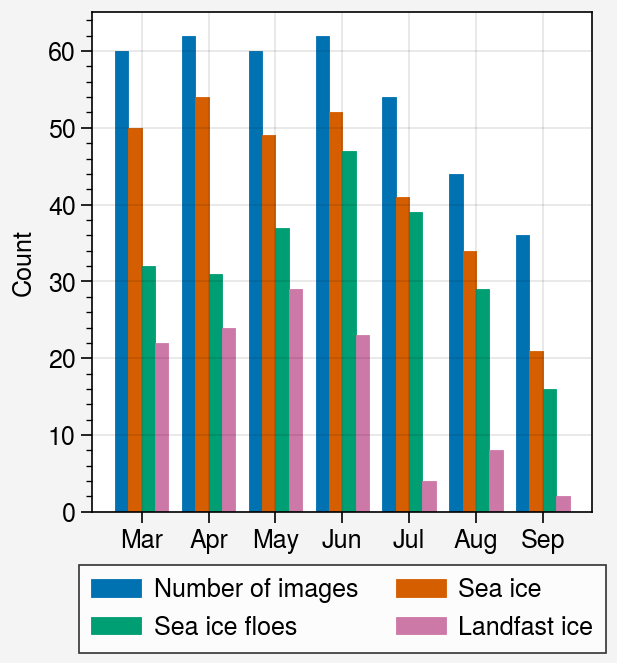

In [28]:
import proplot as pplt
fig, ax = pplt.subplots()

all_files = data.copy()
all_files['month'] = data['start_date'].dt.month
all_files.loc[:, 'visible_sea_ice'] = all_files.loc[:, 'visible_sea_ice'].where(all_files.loc[:, 'visible_sea_ice']=='yes')
all_files.loc[:, 'visible_landfast_ice'] = all_files.loc[:, 'visible_landfast_ice'].where(all_files.loc[:, 'visible_landfast_ice']=='yes')
all_files.loc[:, 'visible_floes'] = all_files.loc[:, 'visible_floes'].where(all_files.loc[:, 'visible_floes']=='yes')
all_files.rename({'cloud_fraction_manual': 'Number of images',
                  'visible_sea_ice': 'Sea ice',
                  'visible_floes': 'Sea ice floes',
                  'visible_landfast_ice': 'Landfast ice'}, axis=1, inplace=True)

ax.bar(all_files.loc[:, ['month', 'Number of images', 'Sea ice', 'Sea ice floes', 'Landfast ice']].groupby('month').count())
ax.legend(loc='b', ncols=2)
ax.format(ylabel='Count', xlabel='', xlocator=np.arange(3, 10),
          xformatter=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'],
          xtickminor=False)
fig.save('../figures/data_availability.png', dpi=300)

# Visualize progress

In [45]:
import pandas as pd
import proplot as pplt
import cartopy.crs as ccrs

# Load case data
df = pd.concat([pd.read_csv('../data/validation_tables/' + f) for f in os.listdir('../data/validation_tables/') if '.csv' in f])
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]
df.columns

Index(['case_number', 'region', 'start_date', 'satellite', 'visible_sea_ice',
       'visible_landfast_ice', 'visible_floes', 'cloud_fraction_manual',
       'cloud_category_manual', 'artifacts', 'qa_analyst', 'qa_reviewer',
       'fl_analyst', 'fl_reviewer', 'notes', 'cloud_fraction',
       'cloud_category', 'fl_analyst_comparison'],
      dtype='object')

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


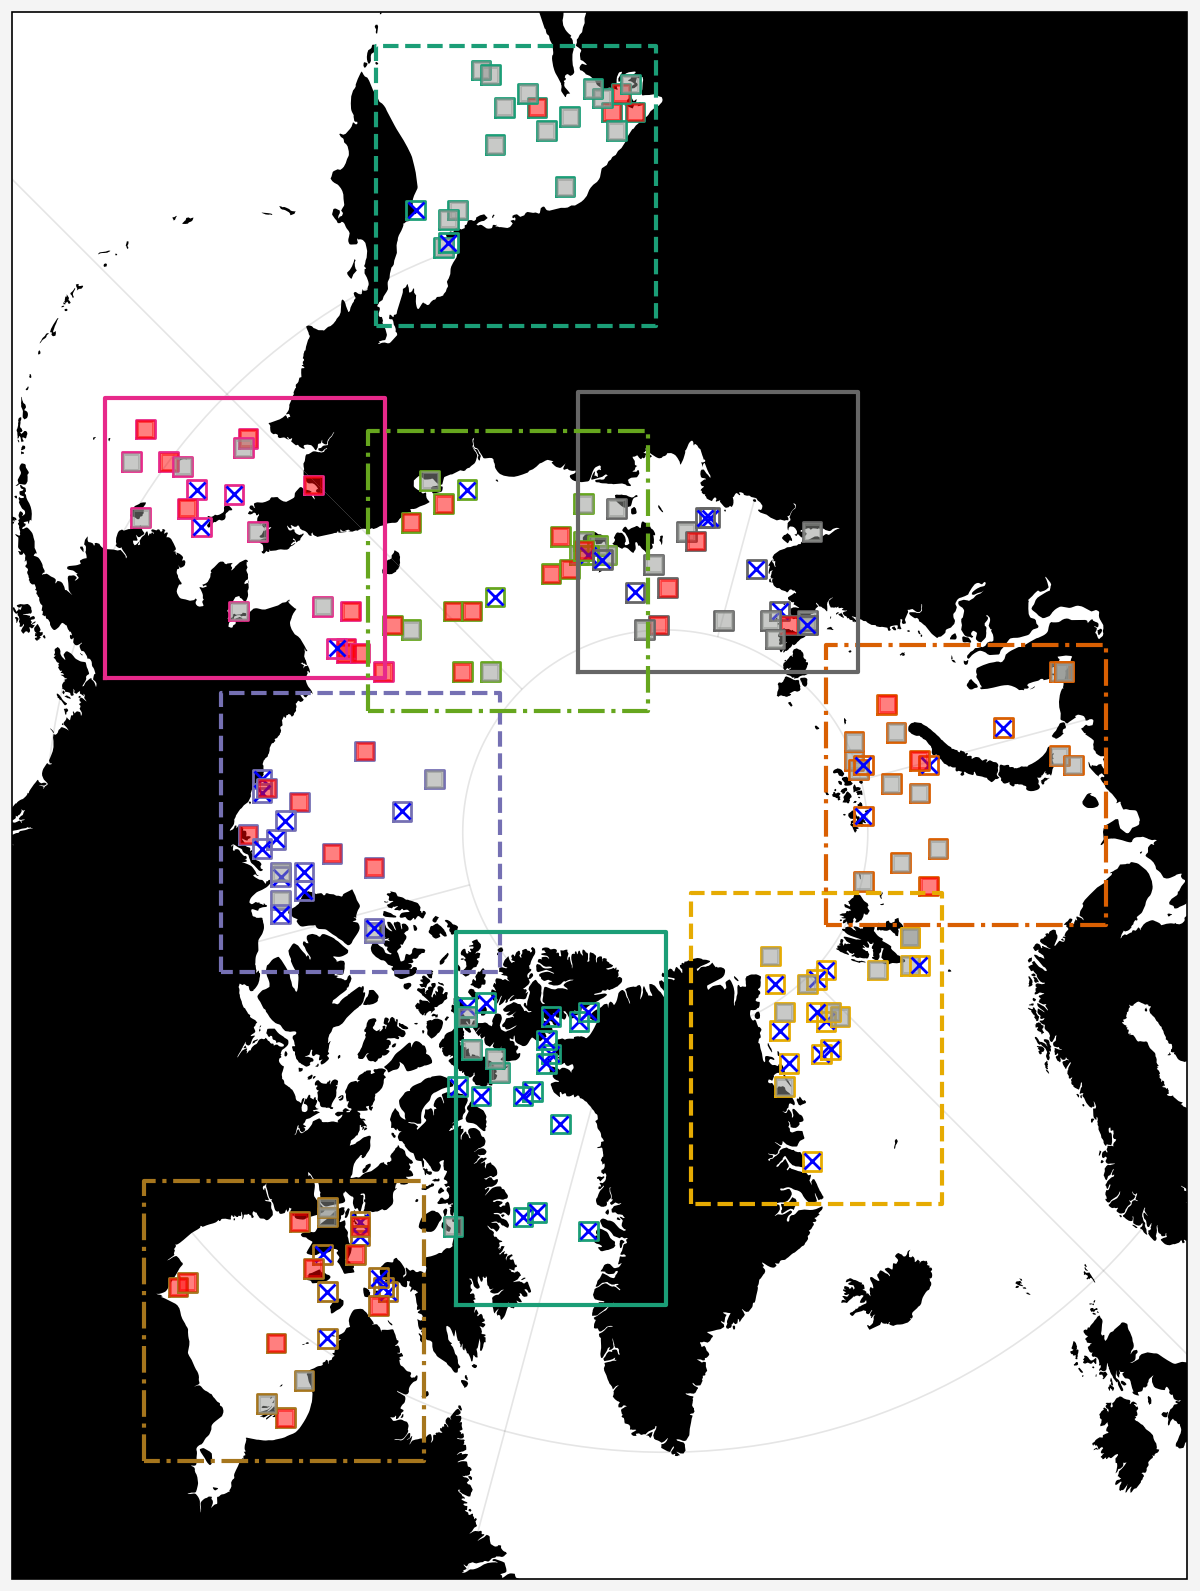

In [48]:
pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, ax = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=1)
ax.format(land=True, landzorder=0)

validated_cases = df.loc[df.fl_analyst.notnull()]
needs_validation = df.loc[df.fl_analyst.isnull() & (df.visible_floes == 'yes')]

no_floes_cases = df.loc[df.visible_floes == 'no']

for idx, region, lat, lon in zip(range(len(regions)), regions.index, regions.center_lat, regions.center_lon):

    xbox = np.array(regions.loc[region, ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']].astype(float))
    ybox = np.array(regions.loc[region, ['lower_y', 'top_y', 'top_y', 'lower_y', 'lower_y']].astype(float))
    
    ax.plot(xbox, ybox, transform=ccrs.CRS('epsg:3413'),
            label='({n}) {t}'.format(n=idx + 1, t=regions.loc[region, 'print_title']), 
               color=colors[region], ls=linestyles[region], m='', zorder=5, lw=1.5)
    
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)
for idx, case in df_all.iterrows():
    x0 = case.center_x
    y0 = case.center_y
    left = x0 - 50e3
    right = x0 + 50e3
    bottom = y0 - 50e3
    top = y0 + 50e3 
    region = case.region

    ax.plot([left, left, right, right, left],
        [bottom, top, top, bottom, bottom], label='', transform=crs, color=colors[region], lw=1)
    if str(case.case_number).zfill(3) + '_aqua' in validated_cases.index:
        ax.plot(x0, y0, m='x', color='b', transform=crs)
    elif str(case.case_number).zfill(3) + '_aqua' in no_floes_cases.index:
        ax.plot(x0, y0, m='s', color='gray', transform=crs, alpha=0.5)
    elif str(case.case_number).zfill(3) + '_aqua' in needs_validation.index:
        ax.plot(x0, y0, m='s', color='r', transform=crs, alpha=0.5)        

In [52]:
df['floe_labels'] = df.fl_analyst.notnull()
df.loc[(df.visible_floes=='yes') & (df.satellite=='aqua')].groupby(['region', 'floe_labels']).count()['case_number']

region                      floe_labels
baffin_bay                  True           16
barents_kara_seas           False           3
                            True            4
beaufort_sea                False           6
                            True           11
bering_strait               False          10
                            True            4
chukchi_east_siberian_seas  False          10
                            True            3
greenland_sea               True           11
hudson_bay                  False           9
                            True            8
laptev_sea                  False           4
                            True            7
sea_of_okhostk              False           4
                            True            2
Name: case_number, dtype: int64

# Renaming and moving files from the updated IFT Pipeline workflow

Each case has a folder, and the folder contains a subfolder called "work" that has all the output. However, not every case ran properly. When no floes are found, the labeled CSV and labeled image are not created, and so the floe tracker doesn't run. 

- the binarized landmask is created though, which I can use instead of making the image with the color picker tool

Files produced:
- work/floes.tracked.csv
- work/overpass-times.csv
- work/YYYYMMDD.250m.satellite/landmask.binarized.tiff
- work/YYYYMMDD.250m.satellite/labeled.props.csv
- work/YYYYMMDD.250m.satellite/labeled.tiff

The labeled tiff is not georeferenced, but the truecolor image is -- it can be used to grab the georeference information if needed. Alternatively, the tiff file can be converted to PNG to reduce size.

The destination folder will be structured like the 

In [126]:
cases = os.listdir('../data/ift_lopez-acosta/')
cases = [c for c in cases if c[0] != '.']
cases.sort()
cases

['000-baffin_bay-100km-20040725-20040726',
 '002-baffin_bay-100km-20040921-20040922',
 '004-baffin_bay-100km-20050819-20050820',
 '005-baffin_bay-100km-20050827-20050828',
 '007-baffin_bay-100km-20070605-20070606',
 '008-baffin_bay-100km-20080704-20080705',
 '016-baffin_bay-100km-20090426-20090427',
 '019-baffin_bay-100km-20110506-20110507',
 '021-baffin_bay-100km-20120422-20120423',
 '022-baffin_bay-100km-20130308-20130309',
 '023-baffin_bay-100km-20140329-20140330',
 '024-baffin_bay-100km-20150312-20150313',
 '032-baffin_bay-100km-20190523-20190524',
 '033-baffin_bay-100km-20190925-20190926',
 '036-baffin_bay-100km-20210602-20210603',
 '037-baffin_bay-100km-20210804-20210805',
 '045-baffin_bay-100km-20220530-20220531',
 '046-baffin_bay-100km-20220617-20220618',
 '048-baffin_bay-100km-20220911-20220912',
 '049-barents_kara_seas-100km-20030902-20030903',
 '050-barents_kara_seas-100km-20040519-20040520',
 '052-barents_kara_seas-100km-20040916-20040917',
 '061-barents_kara_seas-100km-200

In [132]:
cases = os.listdir('../data/ift_lopez-acosta/')
cases = [c for c in cases if c[0] != '.']
cases.sort()

for case in cases:
    if 'sea_of_okhostk' in case:
        print(case)
    case_number, region, dx, startdate, enddate = case.split('-')
    dataloc = '../data/ift_lopez-acosta/{c}/work/'.format(c=case)
    
    for satellite in ['aqua', 'terra']:
        date_folder = '{sd}.250m.{sat}'.format(sd=startdate, sat=satellite)
        if date_folder in os.listdir(dataloc):
            contents = os.listdir(dataloc + '/' + date_folder)
    
            # Copy binarized land mask
            old_path = dataloc + '/' + date_folder + '/landmask.binarized.tiff'
            new_path = "../data/validation_images/landmask_binarized/" + '-'.join(
                [case_number, region, startdate, satellite, 'landmask_binarized.tiff'])
            if 'landmask.binarized.tiff' in contents:    
                ! mv $old_path $new_path
            elif satellite=='aqua':
                if not os.path.exists(new_path):
                    print(case_number, 'landmask error')

            # Copy labeled image
            old_path = dataloc  + '/' + date_folder + '/labeled.tiff'
            new_path = "../data/segmented_images/ift_default_labeled_floes/" + '-'.join(
                [case_number, region, startdate, satellite, 'labeled_floes.tiff'])
            
            if 'labeled.tiff' in contents:
                if not os.path.exists(new_path):
                    ! mv $old_path $new_path
                
            elif satellite=='aqua':
                if not os.path.exists(new_path):
                    pass
                    # print(case_number, 'no labeled image,', 'visible floes=', df.loc['{cn}_{sat}'.format(cn=case_number, sat=satellite), 'visible_floes'])

            # Copy MODIS images
            # 1. Cloud fraction
            old_path = dataloc + '/' + date_folder + '/cloud.tiff'
            new_path = "../data/modis/cloudfraction/" + '-'.join(
                [case_number, region, dx, startdate]) + '.' + satellite + '.cloudfraction.250m.tiff'
            if os.path.exists(old_path):
                ! mv $old_path $new_path

            # 2. True color
            old_path = dataloc + '/' + date_folder + '/truecolor.tiff'
            new_path = "../data/modis/truecolor/" + '-'.join(
                [case_number, region, dx, startdate]) + '.' + satellite + '.truecolor.250m.tiff'
            if os.path.exists(old_path):
                ! mv $old_path $new_path
            

            # 3. False color
            old_path = dataloc + '/' + date_folder + '/falsecolor.tiff'
            new_path = "../data/modis/falsecolor/" + '-'.join(
                [case_number, region, dx, startdate]) + '.' + satellite + '.falsecolor.250m.tiff'
            if os.path.exists(old_path):
                ! mv $old_path $new_path

        else:
            print(case_number, 'work folder empty', dataloc)

046 landmask error
050 landmask error
073 landmask error
079 landmask error
083 landmask error
115 landmask error
116 landmask error
165 landmask error
178 landmask error
202 landmask error
222 landmask error
238 landmask error
401-sea_of_okhostk-100km-20090524-20090525
402-sea_of_okhostk-100km-20100308-20100309
403-sea_of_okhostk-100km-20100417-20100418
418-sea_of_okhostk-100km-20130614-20130615
422-sea_of_okhostk-100km-20140312-20140313
431-sea_of_okhostk-100km-20160331-20160401
432-sea_of_okhostk-100km-20170428-20170429
433-sea_of_okhostk-100km-20170523-20170524
435-sea_of_okhostk-100km-20190427-20190428
439-sea_of_okhostk-100km-20210405-20210406
440-sea_of_okhostk-100km-20220524-20220525
457-sea_of_okhostk-100km-20110504-20110505
458-sea_of_okhostk-100km-20050606-20050607
459-sea_of_okhostk-100km-20090618-20090619
460-sea_of_okhostk-100km-20090608-20090609
461-sea_of_okhostk-100km-20140605-20140606
462-sea_of_okhostk-100km-20070315-20070316
463-sea_of_okhostk-100km-20140308-2014030

case_number                                                        048
region                                                      baffin_bay
start_date                                         2022-09-11 00:00:00
satellite                                                         aqua
visible_sea_ice                                                    yes
visible_landfast_ice                                                no
visible_floes                                                      yes
cloud_fraction_manual                                              0.4
cloud_category_manual                                              NaN
artifacts                                                          yes
qa_analyst                                                       ethan
qa_reviewer                                                     daniel
fl_analyst                                                      daniel
fl_reviewer                                                        NaN
notes 

In [111]:
# Checking hypothesis: blank landmask connected to missing labeled image?
print('Case', 'Region', 'Labeled', 'NonemptyLandmask', 'EmptyLabeled')
for case in cases:
    case_number, region, dx, startdate, enddate = case.split('-')

    # check if labeled image exists
    for satellite in ['aqua']:
        fname = '-'.join([case_number, region, startdate, satellite, 'labeled_floes.tiff'])
        lb_image_exists = os.path.exists('../data/segmented_images/ift_default_labeled_floes/' + fname)
        fname = '-'.join([case_number, region, startdate, satellite, 'landmask_binarized.tiff'])
        try:
            landmask_binarized = PIL.Image.open('../data/validation_images/landmask_binarized/' + fname)
            
            any_not_blank = np.any(np.array(landmask_binarized))
        except:
            any_not_blank = np.nan
        print(case_number, region, lb_image_exists, any_not_blank, lb_image_exists & (not any_not_blank))

Case Region Labeled NonemptyLandmask EmptyLabeled
000 baffin_bay False False False
002 baffin_bay False True False
004 baffin_bay False True False
005 baffin_bay False True False
007 baffin_bay False False False
008 baffin_bay False False False
016 baffin_bay True True False
019 baffin_bay False True False
021 baffin_bay False True False
022 baffin_bay True True False
023 baffin_bay True True False
024 baffin_bay True True False
032 baffin_bay True True False
033 baffin_bay False True False
036 baffin_bay False False False
037 baffin_bay False True False
045 baffin_bay False False False
046 baffin_bay False nan False
048 baffin_bay False True False
049 barents_kara_seas False False False
050 barents_kara_seas False nan False
052 barents_kara_seas False False False
061 barents_kara_seas False False False
070 barents_kara_seas False False False
071 barents_kara_seas False False False
072 barents_kara_seas False False False
073 barents_kara_seas False nan False
074 barents_kara_seas False

In [60]:
landmask

In [95]:
import PIL

True